In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
!pip install ollama langchain-ollama datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fs

In [ ]:
!pip install colab-xterm #https://pypi.org/project/colab-xterm/
%load_ext colabxterm
%xterm

#once the terminal starts run the following commands:
#step 1: ollama serve & ollama pull llama3.1 & ollama pull llama2 & ollama pull mistral
#Step 2: ollama pull llama3.1
#Step 3: ollama pull llama2
#Step 4: ollama pull mistral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 3.5 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
# Cell 1: Imports and Setup
import pandas as pd
import torch
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class MetricsCalculator:
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.labels = ['No Fit', 'Potential Fit', 'Good Fit']
        self.label_encoder.fit(self.labels)

    def extract_prediction(self, model_output):
        """Extract the prediction from model output"""
        for label in self.labels:
            if label in model_output:
                return label
        return 'No Fit'  # default if no clear prediction found

    def calculate_metrics(self, y_true, y_pred):
        """Calculate comprehensive metrics"""
        y_true_enc = self.label_encoder.transform(y_true)
        y_pred_enc = self.label_encoder.transform(y_pred)

        precision, recall, f1, support = precision_recall_fscore_support(
            y_true_enc,
            y_pred_enc,
            labels=[0, 1, 2],
            zero_division=0
        )

        conf_matrix = confusion_matrix(y_true_enc, y_pred_enc)

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'confusion_matrix': conf_matrix
        }

    def plot_confusion_matrix(self, conf_matrix):
        """Plot confusion matrix heatmap"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_matrix,
            annot=True,
            fmt='d',
            xticklabels=self.labels,
            yticklabels=self.labels
        )
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def print_metrics(self, metrics, model_name=""):
        """Print metrics in a readable format"""
        print(f"\nDetailed Metrics for {model_name}:")
        print("-" * 40)

        for i, label in enumerate(self.labels):
            print(f"\n{label}:")
            print(f"Precision: {metrics['precision'][i]:.3f}")
            print(f"Recall: {metrics['recall'][i]:.3f}")
            print(f"F1-score: {metrics['f1'][i]:.3f}")
            print(f"Support: {metrics['support'][i]}")

        print("\nMacro Averages:")
        print(f"Precision: {np.mean(metrics['precision']):.3f}")
        print(f"Recall: {np.mean(metrics['recall']):.3f}")
        print(f"F1-score: {np.mean(metrics['f1']):.3f}")

In [ ]:
# Cell 3: Model Configuration
class ModelConfig:
    MODELS = {
        'llama3.1': {
            'type': 'ollama',
            'name': 'llama3.1'
        },
        'llama2': {
            'type': 'ollama',
            'name': 'llama2'
        },
        'mistral': {
            'type': 'ollama',
            'name': 'mistral'
        }
    }

In [ ]:
class PromptTemplates:
    @staticmethod
    def zero_shot_prompt(resume_text, job_description):
        return f"""You are an expert resume matcher. Determine if this resume is a Good Fit, Potential Fit, or No Fit.

Resume:
{resume_text}

Job Description:
{job_description}

Follow these EXACT rules for classification:

1. Good Fit REQUIRES:
- Direct match in professional domain (e.g. software engineer for software role)
- Required technical skills are present
- Experience level matches requirements
ALL THREE must be present for Good Fit.

2. No Fit if ANY of these are true:
- Complete domain mismatch (e.g. sales vs engineering)
- Missing ALL critical technical skills
- Experience level far below requirements

3. Potential Fit if:
- Same general domain but some skill gaps
- Has transferable skills relevant to role
- Meets some but not all key requirements

First identify the exact domain, skills, and experience required.
Then compare directly to resume qualifications.
Finally classify based on the rules above. Only output one of the three categories.

Your classification MUST follow these rules exactly."""

    @staticmethod
    def chain_of_thought_prompt(resume_text, job_description):
        return f"""Analyze this resume-job match step by step:

Resume:
{resume_text}

Job Description:
{job_description}

Required steps:

1. Job Requirements Analysis:
- List exact professional domain
- List required technical skills
- List required experience level

2. Resume Analysis:
- List candidate's professional domain
- List candidate's technical skills
- List candidate's experience level

3. Direct Comparison:
Domain Match: [Yes/No]
Skills Match: [Full/Partial/None]
Experience Match: [Yes/No]

4. Classification Rules:
Good Fit = Domain[Yes] + Skills[Full] + Experience[Yes]
No Fit = Domain[No] OR Skills[None] OR Experience far below
Potential Fit = Partial matches that aren't Good or No Fit

Provide your final classification with specific evidence. Only output one of the three categories."""

    @staticmethod
    def two_shot_prompt(resume_text, job_description, additional_resume_text1, additional_job_desc1, additional_resume_text2, additional_job_desc2):
        return f"""Here are two examples with detailed reasoning:

Example 1:
Resume: {additional_resume_text1}
Job Description: {additional_job_desc1}
Analysis:
- Domain: Exact match (software engineering)
- Skills: Full match (Java development)
- Experience: Meets requirements (5 years)
Decision: Good Fit (matches all criteria)

Example 2:
Resume: {additional_resume_text2}
Job Description: {additional_job_desc2}
Analysis:
- Domain: Complete mismatch (sales vs engineering)
- Skills: No relevant technical skills
- Experience: Wrong type of experience
Decision: No Fit (fails all criteria)

Now analyze this pair:

Resume:
{resume_text}

Job Description:
{job_description}

Analyze using EXACT same criteria:
1. Domain match
2. Skills match
3. Experience match

Then classify based on:
- Good Fit: Matches ALL criteria
- No Fit: Fails ANY criteria completely
- Potential Fit: Partial matches
Only output one of the three categories."""

In [ ]:
class MultiModelResumeAnalyzer:
    def __init__(self, model_key):
        print(f"Initializing {model_key}...")
        self.model_config = ModelConfig.MODELS[model_key]
        self.setup_model()

    def setup_model(self):
        try:
            if torch.cuda.is_available():
                print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
                self.device = "cuda"
            else:
                print("CUDA not available. Using CPU.")
                self.device = "cpu"

            if self.model_config['type'] == 'ollama':
                self.model = OllamaLLM(
                    model=self.model_config['name'],
                    device=self.device,
                    temperature=0.7,
                    top_p=0.9,
                    max_input_token=4096
                )
            print("Model loaded successfully")
        except Exception as e:
            print(f"Error loading model: {str(e)}")

    def get_improvement_suggestions(self, resume_text, job_description, predicted_fit):
        """Get improvement suggestions for Potential Fit or No Fit cases"""
        if predicted_fit in ['Potential Fit', 'No Fit']:
            prompt = f"""Given this resume and job description, provide specific, actionable improvements the candidate should make:

Job Description:
{job_description}

Resume:
{resume_text}

Current Fit Level: {predicted_fit}

List 3-5 specific improvements that would help this candidate become a better fit for the role:
1)"""
            return self.model.invoke(prompt)
        return None

    def analyze_single_pair(self, row, additional):
        try:
            resume_text = str(row['resume_text'])
            job_desc = str(row['job_description_text'])
            actual_label = str(row['label'])

            additional_resume_text1 = str(additional[0]['resume_text'])
            additional_job_desc1 = str(additional[0]['job_description_text'])

            additional_resume_text2 = str(additional[1]['resume_text'])
            additional_job_desc2 = str(additional[1]['job_description_text'])

            # Generate analyses using different prompts
            zero_shot = self.model.invoke(
                PromptTemplates.zero_shot_prompt(resume_text, job_desc)
            )
            two_shot = self.model.invoke(
                PromptTemplates.two_shot_prompt(resume_text, job_desc, additional_resume_text1, additional_job_desc1, additional_resume_text2, additional_job_desc2)
            )
            cot = self.model.invoke(
                PromptTemplates.chain_of_thought_prompt(resume_text, job_desc)
            )

            # Get prediction for improvement suggestions
            metrics_calc = MetricsCalculator()
            predicted_fit = metrics_calc.extract_prediction(cot)
            improvements = self.get_improvement_suggestions(resume_text, job_desc, predicted_fit)

            return {
                'zero_shot': zero_shot,
                'two_shot': two_shot,
                'chain_of_thought': cot,
                'actual_label': actual_label,
                'improvements': improvements if improvements else "No improvements needed"
            }
        except Exception as e:
            print(f"Error in analysis: {str(e)}")
            return None

In [ ]:
def load_dataset():
    try:
        splits = {'train': 'train.csv', 'test': 'test.csv'}
        df = pd.read_csv("hf://datasets/cnamuangtoun/resume-job-description-fit/" + splits["train"])
        print("\nDataset Info:")
        print(f"Total samples: {len(df)}")
        print("\nLabel Distribution:")
        print(df['label'].value_counts())
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [ ]:
def analyze_with_model(model_key, sample_size=3):
    df = load_dataset()
    if df is None:
        return

    print(f"\nTesting with {model_key}")
    analyzer = MultiModelResumeAnalyzer(model_key)
    metrics_calc = MetricsCalculator()

    # Select balanced samples
    good_fit = df[df['label'] == 'Good Fit'].sample(n=sample_size+1)
    potential_fit = df[df['label'] == 'Potential Fit'].sample(n=sample_size)
    no_fit = df[df['label'] == 'No Fit'].sample(n=sample_size+1)

    main_good_fit = good_fit.iloc[:-1]
    additional_good_fit = good_fit.iloc[-1:]

    main_no_fit = no_fit.iloc[:-1]
    additional_no_fit = no_fit.iloc[-1:]

    samples = pd.concat([main_good_fit, potential_fit, main_no_fit])

    print(f"\nAnalyzing {len(samples)} resume-job pairs...")
    true_labels = []
    zero_shot_predictions = []
    two_shot_predictions = []
    cot_predictions = []

    for idx, row in tqdm(samples.iterrows(), total=len(samples)):
        results = analyzer.analyze_single_pair(row, additional=[additional_good_fit, additional_no_fit])
        if results:
            print(f"\nAnalyzing Pair {idx}:")
            print(f"Actual Label: {results['actual_label']}")

            print("\nZero-shot Analysis:")
            print(results['zero_shot'])

            print("\nTwo-shot Analysis:")
            print(results['two_shot'])

            print("\nChain of Thought Analysis:")
            print(results['chain_of_thought'])

            if results['improvements'] != "No improvements needed":
                print("\nImprovement Suggestions:")
                print(results['improvements'])

            true_labels.append(results['actual_label'])
            zero_shot_predictions.append(metrics_calc.extract_prediction(results['zero_shot']))
            two_shot_predictions.append(metrics_calc.extract_prediction(results['two_shot']))
            cot_predictions.append(metrics_calc.extract_prediction(results['chain_of_thought']))

        print("-" * 80)

    # Calculate metrics
    approaches = {
        'Zero-shot': zero_shot_predictions,
        'Two-shot': two_shot_predictions,
        'Chain-of-Thought': cot_predictions
    }

    for approach_name, predictions in approaches.items():
        print(f"\n{model_key} - {approach_name} Results:")
        metrics = metrics_calc.calculate_metrics(true_labels, predictions)
        metrics_calc.print_metrics(metrics, approach_name)
        metrics_calc.plot_confusion_matrix(metrics['confusion_matrix'])

    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Dataset Info:
Total samples: 6241

Label Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64

Testing with llama3.1
Initializing llama3.1...
CUDA is available. Using GPU: Tesla T4
Model loaded successfully

Analyzing 15 resume-job pairs...


  7%|▋         | 1/15 [01:18<18:24, 78.87s/it]


Analyzing Pair 4816:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the job description, here are the exact domain, skills, and experience required:

**Domain:** Data Engineering
**Required Skills:**

1. Experience with SQL and cloud-based analytical data warehouses (Snowflake preferred)
2. Expertise building end-to-end data pipelines using Airflow and dbt (data build tool) or comparable technologies
3. Strong data modeling skills and familiarity with the Kimball data warehousing methodology
4. Experience writing Python code for data processing
5. Git and command line experience
6. Familiarity with AWS and CloudFormation, or comparable cloud services and IaC tools (preferred)
7. Docker and Docker Compose experience (preferred)

**Experience:**

1. 8+ years of experience in data science, software engineering, or related technical fields

Now, let's compare these requirements to the resume qualifications:

The domain is not a direct match, but it's close; the resume has HR-related

 13%|█▎        | 2/15 [01:53<11:30, 53.14s/it]


Analyzing Pair 5642:
Actual Label: Good Fit

Zero-shot Analysis:
After analyzing the job description and resume, I have identified the following:

**Domain**: Accounting/Financial Management
**Critical Technical Skills**:
	* Advanced accounting knowledge (insurance accounting a plus)
	* MS Office suite (specifically Excel)
	* General Ledger Accounting
	* Financial Statement Preparation
	* Bank Reconciliations
	* Accounts Payable and Receivable management
**Experience Level**: 7+ years of experience as a seasoned senior accountant

Comparing the resume to these requirements:

The domain is a direct match (Accounting/Financial Management). The resume lists relevant technical skills, including General Ledger Accounting, Financial Statement Preparation, Bank Reconciliations, and Accounts Payable management. However, insurance accounting is not explicitly mentioned in the resume.

Experience level matches the requirement of 7+ years of experience as a seasoned senior accountant.

However, 

 20%|██        | 3/15 [02:51<10:59, 54.97s/it]


Analyzing Pair 6042:
Actual Label: Good Fit

Zero-shot Analysis:
After analyzing the job description and resume, I have identified the following:

**Domain:** Software Engineer in Machine Learning
**Required Technical Skills:**
	* Experience with developing machine learning models at scale from inception to business impact
	* Knowledge of C++ and Java or experience with scripting languages such as Python, Perl, PHP, and/or shell scripts
**Experience Level:** 6+ years of experience in software engineering (or 4+ years with a PhD)

Now, let's compare these requirements to the resume qualifications:

The domain is "Software Engineer in Machine Learning", which matches the job description. The required technical skills are mostly present on the resume, as the candidate has experience with developing machine learning models and working with scripting languages like Python. However, there is no mention of C++ or Java experience.

Experience-wise, the candidate has around 10 years of combine

 27%|██▋       | 4/15 [03:36<09:24, 51.30s/it]


Analyzing Pair 5757:
Actual Label: Good Fit

Zero-shot Analysis:
After carefully reviewing the job description and the resume provided, I have identified the following:

**Domain:** The exact domain is "Sr Business Systems Database Software Engineer" which involves designing, implementing, and optimizing data architecture to support business intelligence and financial reporting functions.

**Required Technical Skills:**

1. Proficiency in Microsoft Azure services and architecture
2. Experience with cloud-based data warehousing solutions
3. Strong working knowledge of SQL databases, data modeling, and performance optimization techniques
4. Proven experience developing Python APIs for data retrieval and integration
5. Advanced skills in Microsoft Excel for building financial and operational reports

**Experience Level:** The job requires 5+ years of professional experience.

Now, let's compare these requirements to the resume qualifications:

The resume presents a candidate with experie

 33%|███▎      | 5/15 [04:10<07:29, 44.90s/it]


Analyzing Pair 6229:
Actual Label: Good Fit

Zero-shot Analysis:
**Classification:**

The job description requires a Senior Software Engineer with expertise in Java (11 or 17+), AWS Cloud Platform, data modeling, microservices, Docker, Kubernetes, and Python programming. The role also demands experience as a leader and mentor, with strong communication skills.

Comparing the resume to these requirements:

**Domain:** The domain is software engineering, specifically cloud-based development.
**Skills:**
	* Required technical skills present on the resume:
		+ Java (Software Engineer of IoT Cloud mentions "Java" but no specific version)
		+ AWS Cloud Platform (Software Engineer of IoT Cloud mentions provision and manage AWS resources)
		+ Microservices (Software Engineer of IoT Cloud mentions micro-services, Kafka, Storm, Spark, Cassandra, Kubernetes)
		+ Docker (Software Engineer of IoT Cloud mentions "docker")
	* Missing skills:
		+ Python programming is mentioned on the resume, but it'

 40%|████      | 6/15 [05:05<07:14, 48.25s/it]


Analyzing Pair 4164:
Actual Label: Potential Fit

Zero-shot Analysis:
After carefully analyzing the resume and job description, I have determined that this candidate is a:

**Potential Fit**

Here's why:

* **Domain**: The job requires Java development skills in an Agile environment, which falls under the software engineering domain. The candidate has experience as a Software Test Engineer, but also has experience with programming languages such as C#, C++, Java, and JavaScript.
* **Skills**: While the resume doesn't explicitly mention Java or JEE (Java Enterprise Edition) skills, it does list relevant programming languages like Java, Spring Framework, Hibernate, and ExtJS Framework. However, it's missing some key technical skills required for the role, such as Spring Boot, Microservices, and MongoDB.
* **Experience**: The candidate has around 8 years of experience in software development, which is close to the required 8+ years of experience in Java/JEE space.

While the candidate do

 47%|████▋     | 7/15 [05:58<06:40, 50.02s/it]


Analyzing Pair 4040:
Actual Label: Potential Fit

Zero-shot Analysis:
After carefully analyzing the job description and the resume, I conclude that this candidate is a **Potential Fit** for the Staff Data Engineer position at Direct Supply, Inc.

Here's why:

**Domain**: The domain of data engineering aligns with the general field of technology, but there are some specific skills required for the role that may not be directly related to the candidate's experience in data entry and administrative support. However, this is a common situation where transferable skills can be applied to a new domain.

**Technical Skills**: The resume mentions proficiency in Microsoft Office and G Suite, but it does not explicitly mention technical skills such as Python, Spark SQL, or database management technologies that are required for the role. While the candidate has experience with data entry and database management, it's unclear if they have hands-on experience with complex queries across large data

 53%|█████▎    | 8/15 [06:52<05:57, 51.05s/it]


Analyzing Pair 3823:
Actual Label: Potential Fit

Zero-shot Analysis:
**Domain:** The job description specifies that the company is an "entrepreneurial accounting and consulting firm" with a focus on advising and supporting business owners. This indicates that the domain is Accounting/Financial Consulting.

**Required Technical Skills:**

* Experience with accounting software (QuickBooks, Excel)
* Tax preparation experience
* Strong written and verbal communication skills

The resume lists proficiency in various accounting software, including MS Office Suite, which includes Excel. However, it does not specifically mention QuickBooks.

**Experience Level:** The job posting requires 5-10 years of experience, while the resume shows a candidate with 3+ years of experience as a Financial Accountant.

Based on these requirements, I will now classify the resume:

**No Fit**

The domain is directly related to accounting and finance, which matches the job description. However, the candidate la

 60%|██████    | 9/15 [07:50<05:20, 53.42s/it]


Analyzing Pair 4424:
Actual Label: Potential Fit

Zero-shot Analysis:
**Domain:** Software Development Engineer for Mada (mobile app development, full-stack development)

**Required Technical Skills:**

1. Cordova and JavaScript
2. PHP and Laravel
3. React and related technologies
4. Docker
5. Elastic Search
6. OOP and data structures

**Experience Level:** 3-5 years of relevant work experience (or 2-4 years with a Master's degree)

Now, let's compare these requirements to the provided resume.

The resume shows a software engineer with experience in various domains, including mobile app development and full-stack development. Here are some key qualifications:

* Mobile app development: The candidate has experience developing iOS applications using Cordova and JavaScript.
* PHP application development: The candidate has experience developing server-side applications using PHP and Laravel (although it's not explicitly stated as a primary skill).
* React front-end development: Not mentio

 67%|██████▋   | 10/15 [08:46<04:31, 54.27s/it]


Analyzing Pair 4493:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the job description provided by ROR Partners, I will classify this role as a "Good Fit" for someone with the following qualifications:

**Domain:** Data Engineering
**Skills:**

* ETL and ELT data pipelines
* Snowflake data warehouse using dbt
* Python programming for data processing
* Airflow and integration platforms
* SQL and cloud-based analytical data warehouses (Snowflake preferred)
* Git, command line, Docker, and Docker Compose experience

**Experience:** 8+ years of experience in data science, software engineering or related technical fields.

The candidate's resume does not explicitly mention working with Snowflake, dbt, Airflow, or Python for data processing. However, the skills listed on the resume (ETL Tools: Ab Initio, Scripting Languages: Unix shell scripting, Python, Cloud Services: Microsoft Azure Cloud Services) suggest that the candidate has some experience in ETL/ELT patterns and best pr

 73%|███████▎  | 11/15 [09:44<03:40, 55.17s/it]


Analyzing Pair 2863:
Actual Label: No Fit

Zero-shot Analysis:
**Domain:** The job description specifies that the domain is Salesforce Communications Cloud Business Analyst, which falls under the broader category of software development and cloud computing.

**Required Technical Skills:**

1. Experience in Salesforce Industries Communications cloud (10+ years)
2. Certification in Salesforce (a plus)
3. 5+ years of experience in Telecom domain solutioning for Quote to Cash
4. Architectural skills using Vlocity, Omnistudio, Salesforce API framework, and 3rd party APIs
5. Solution design on the Vlocity platform
6. Strong understanding of Salesforce capabilities and limitations
7. Experience reviewing and documenting code
8. Knowledge on Source Control & deployments to higher environments

**Experience Level:** The job requires at least 10+ years of experience in Salesforce Industries Communications cloud, with a plus for certification.

Now, let's compare these requirements to the resume

 80%|████████  | 12/15 [10:30<02:37, 52.61s/it]


Analyzing Pair 1107:
Actual Label: No Fit

Zero-shot Analysis:
After carefully analyzing the job description and the resume, here is my classification:

**Domain:** The primary domain of this role is **Financial Accounting**, specifically in the Controller's department, with a focus on accounting processes, risk activities, and analysis.
**Required Technical Skills:**
	* Ad Hoc Analysis
	* Financial Accounting
	* Microsoft Excel
	* Oracle
**Experience Level:** The job description mentions "3+ months" contract duration, which implies that experience level is not the primary concern.

Comparing these requirements to the resume:

The resume does not match the domain of **Financial Accounting**. Instead, it's from a Networking and Engineering background, with skills in Network Administration, Cisco/Aruba equipment, and electrical/computer design.
There are no technical skills mentioned in the resume that align with Ad Hoc Analysis, Financial Accounting, Microsoft Excel, or Oracle.
The exp

 87%|████████▋ | 13/15 [11:29<01:48, 54.31s/it]


Analyzing Pair 1721:
Actual Label: No Fit

Zero-shot Analysis:
Based on the job description provided, I have identified the following:

**Domain:** The job is for a Lead Software Engineer with a focus on cybersecurity in the power engineering community.

**Required Technical Skills:**

* Programming languages: C#, Python
* Familiarity with industrial control systems and information security
* Experience with firmware/software development
* Knowledge of hardware and software interactions

**Experience Level:** 6+ years of experience in one or more of the areas mentioned above.

Now, let's compare these requirements to the resume qualifications:

The resume belongs to a computer engineer with experience in software development, programming languages such as C#, Python, HTML, SQL, and JavaScript. The candidate has also worked on projects related to cybersecurity, including creating a system for pre-assessing malignant melanoma using image processing algorithms.

**Direct Match:** Yes, th

 93%|█████████▎| 14/15 [12:22<00:53, 54.00s/it]


Analyzing Pair 986:
Actual Label: No Fit

Zero-shot Analysis:
**Domain:** The job description requires a professional with expertise in servicing critical power equipment, executing service work according to client standard processes and safety guidelines, and delivering excellent customer service. This domain is primarily related to electrical engineering, maintenance, and repair services.

**Required Technical Skills:**

* Ability to interact and communicate (written and verbal) information to varying levels within the organization
* Advanced level of ability to use Microsoft Office products
* Moderate ability to self-Project Manage using MS Project or Excel

**Experience Level:** The job description requires a Bachelor's degree in Electrical Engineering, Electrical Engineering Technology, or equivalent military experience, or an Associate's Degree with 2+ years of experience in servicing critical power equipment. Alternatively, a High School Diploma/GED and 10+ years of experience 

100%|██████████| 15/15 [13:17<00:00, 53.18s/it]


Analyzing Pair 483:
Actual Label: No Fit

Zero-shot Analysis:
**Domain:** Business Analysts with Logistics Management
**Skills:**

* Expertise in handling TMS (Transportation Management System) similar logistics modules
* Deep functional and domain expertise in configuration of TMS product with subject matter knowledge in areas such as:
	+ Order Management, Planning, load building, Execution, shipment tendering, Visibility, Freight payment and audit, Fleet management, optimizer, Transportation modeler
* Hands on experience working on Transport Management Systems (TMS) such as Manhattan, JDA SAP TMS, OTM, BluJay etc.
* Experience or understanding of intermodal transportation

**Experience:** 

* Participating in business process redesign, roadmap planning, and identifying touchpoints in multi-cloud implementations
* Developing strong client relationships by building trust, rapport, and positive working relationships with both internal and external stakeholders and team members
* Creati

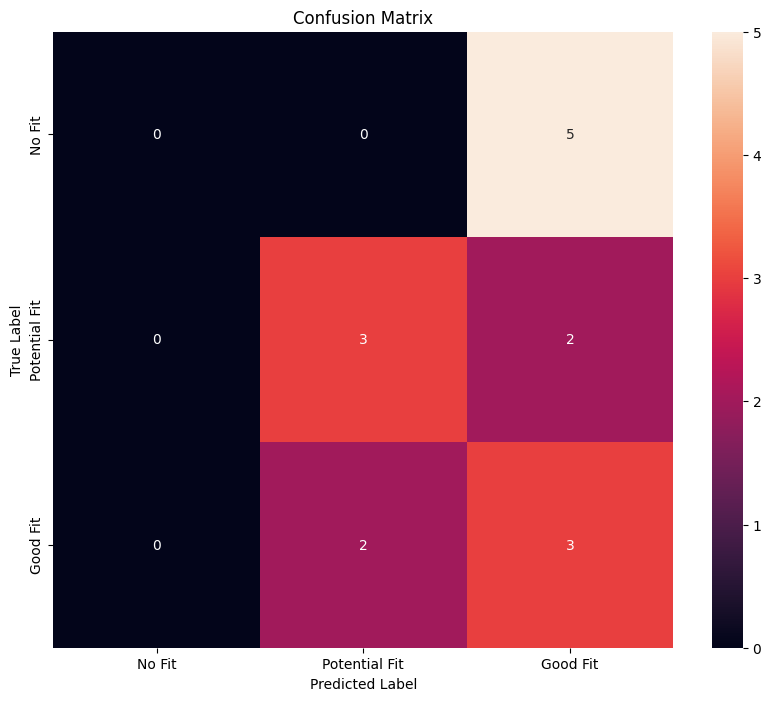


llama3.1 - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Potential Fit:
Precision: 0.500
Recall: 0.800
F1-score: 0.615
Support: 5

Good Fit:
Precision: 0.286
Recall: 0.400
F1-score: 0.333
Support: 5

Macro Averages:
Precision: 0.262
Recall: 0.400
F1-score: 0.316


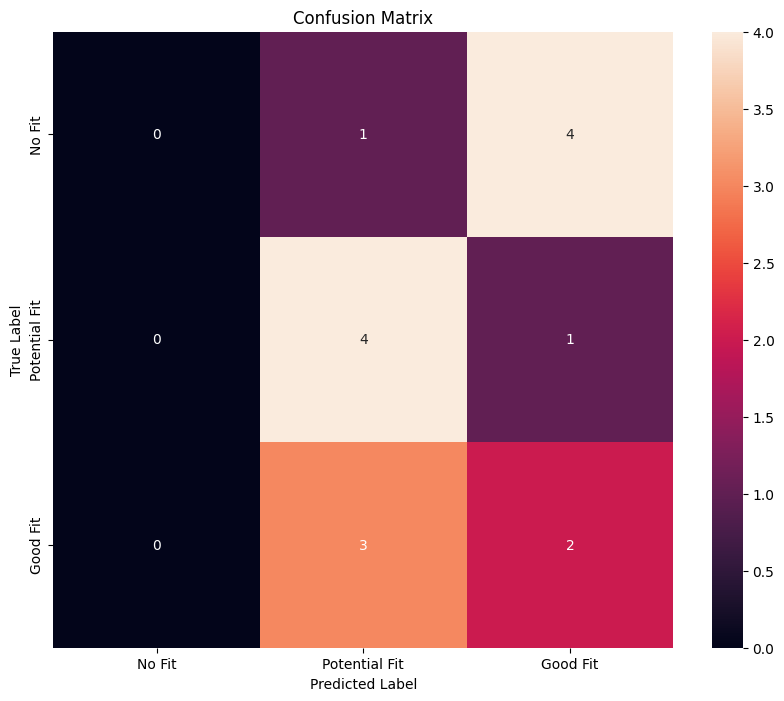


llama3.1 - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 1.000
Recall: 0.600
F1-score: 0.750
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.444
Recall: 0.800
F1-score: 0.571
Support: 5

Macro Averages:
Precision: 0.481
Recall: 0.467
F1-score: 0.440


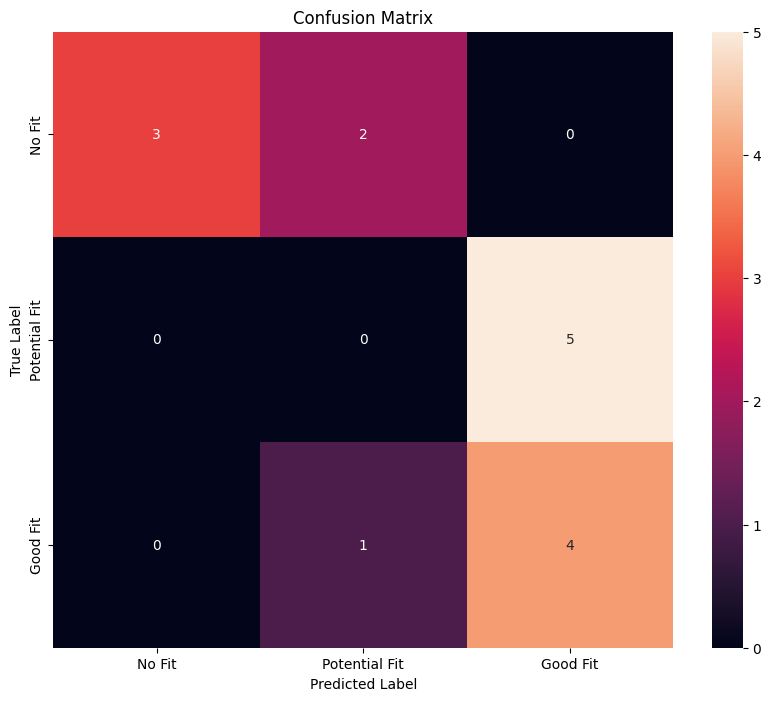

In [ ]:
# Cell 8: Run analysis for specific model
# Choose which model to run:
model_key = 'llama3.1'
analyze_with_model(model_key, sample_size=5)


Dataset Info:
Total samples: 6241

Label Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64

Testing with llama2
Initializing llama2...
CUDA is available. Using GPU: Tesla T4
Model loaded successfully

Analyzing 15 resume-job pairs...


  7%|▋         | 1/15 [00:28<06:36, 28.31s/it]


Analyzing Pair 5933:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the information provided in the job description and the candidate's resume, I would classify the candidate as a Good Fit for the Software Engineer role at Rightware.

The candidate has experience in software engineering, which is a direct match to the professional domain required for the role. They also have the required technical skills, including C++, OpenGL, and Vulkan, and their experience level matches the requirements. Therefore, all three criteria are met for a Good Fit classification.

Therefore, I would classify the candidate as a Good Fit for the Software Engineer role at Rightware.

Two-shot Analysis:
Based on the information provided, I would classify the candidate as a "Potential Fit" as they meet some of the required skills and experience but not all of them. The candidate has experience in C++ programming, graphics programming (OpenGL, Vulkan), and game engines (Unity, Unreal), which are relevant 

 13%|█▎        | 2/15 [00:49<05:11, 23.96s/it]


Analyzing Pair 4818:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the job posting provided, I have classified the candidate as a "Good Fit" for the software engineer role. Here's why:

1. Direct match in professional domain: The candidate has experience in software development, which matches the professional domain required for the role.
2. Required technical skills are present: The candidate has demonstrated expertise in several of the required technical skills, including full-stack development, UI development, backend development, and proficiency in Azure DevOps, Visual Studio, and Git.
3. Experience level matches requirements: The candidate's experience level is consistent with the required experience level for the role.

Therefore, based on the classification rules provided, the candidate is classified as a "Good Fit" for the software engineer role.

Two-shot Analysis:
Based on the information provided, I would classify the candidate as a "Good Fit" for the position. Here'

 20%|██        | 3/15 [01:13<04:51, 24.27s/it]


Analyzing Pair 4938:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the information provided in the job posting, I have classified the candidate as a "Good Fit" for the Accounting Specialist role at Allvue Systems. This is because the candidate's experience and skills match the requirements of the position:

1. Direct match in professional domain: The candidate has experience working in an office environment as a revenue specialist, which aligns with the professional domain of the Accounting Specialist role.
2. Required technical skills are present: The candidate has proficiency in MS Office and NetSuite or Salesforce experience, which are critical technical skills required for the position.
3. Experience level matches requirements: The candidate's experience level is consistent with the requirements of the position, as mentioned in the job posting.

Therefore, based on the criteria provided, I have classified the candidate as a "Good Fit" for the Accounting Specialist role at A

 27%|██▋       | 4/15 [01:32<04:02, 22.05s/it]


Analyzing Pair 6161:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the information provided in the resume, I would classify the candidate as a Good Fit for the position of Software Engineer at X.

The candidate has a Master's degree in Information Technology and Management from Illinois Institute of Technology, which is a direct match to the professional domain required for the software engineer role. They also have the required technical skills, including quality analysis, project management, strategic planning, testing, and implementation. Additionally, their experience level matches the requirements for the position.

Therefore, based on the classification rules provided, the candidate meets all the criteria for a Good Fit and would be a good match for the role.

Two-shot Analysis:
Based on the analysis, the candidate is a Potential Fit for the position at X. The candidate's education and training align with the required skills and experience for the role, and they have some

 33%|███▎      | 5/15 [01:59<03:59, 23.93s/it]


Analyzing Pair 5880:
Actual Label: Good Fit

Zero-shot Analysis:
Based on the provided job posting for an Engineering Manager role at Markforged, I have classified the candidate as a "Good Fit" based on the following reasons:

1. Direct match in professional domain: The candidate has experience in engineering management, which matches the required domain for the role.
2. Required technical skills are present: The candidate has experience with contemporary web development frameworks, cloud systems, and schema design, which aligns with the required technical skills for the role.
3. Experience level matches requirements: The candidate's experience level is consistent with the required experience level for the role.

Therefore, the candidate is classified as a "Good Fit" for the Engineering Manager role at Markforged.

Two-shot Analysis:
Based on the job posting provided, I have analyzed the candidate's profile using the same criteria as the employer:

1. Domain match: The candidate has e

 40%|████      | 6/15 [02:25<03:40, 24.46s/it]


Analyzing Pair 3246:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the provided information, I have classified the candidate as a Good Fit for the Salesforce Business Analyst role. Here's why:

1. Direct match in professional domain: The candidate has experience as a Salesforce Business Analyst, which aligns with the requirements of the job posting.
2. Required technical skills are present: The candidate has experience with Salesforce Lightning, Sales Cloud, and Service Cloud, which are all critical technical skills mentioned in the job posting.
3. Experience level matches requirements: The candidate has at least 10 years of experience as a Salesforce Business Analyst, which is closer to the required 10+ years of experience mentioned in the job posting than any other category.

Therefore, the candidate is a Good Fit for the Salesforce Business Analyst role.

Two-shot Analysis:
Based on the analysis, the candidate has a Good Fit for the Salesforce Business Analyst role. The

 47%|████▋     | 7/15 [02:50<03:18, 24.77s/it]


Analyzing Pair 3748:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the information provided in the job posting, I have classified the candidate as a "Good Fit" for the software engineer role at Google. Here's why:

1. Direct match in professional domain: The candidate has experience as a software engineer, which matches the professional domain required for the role.
2. Required technical skills are present: The candidate has listed their technical skills, including proficiency in programming languages such as Java, Python, and C++, as well as experience with cloud computing platforms like Google Cloud. These skills align with the requirements listed in the job posting.
3. Experience level matches requirements: The candidate has several years of experience in software engineering, which meets the experience level requirement listed in the job posting.

Therefore, based on the classification rules provided, I have classified the candidate as a "Good Fit" for the software eng

 53%|█████▎    | 8/15 [03:14<02:50, 24.41s/it]


Analyzing Pair 3661:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the provided job description, I have classified the candidate as a "Good Fit" for the software engineer role at Truist Financial Corporation. This is because the candidate's professional domain (software engineering) matches the requirements of the job, they possess all the required technical skills, and their experience level is consistent with the job requirements.

Here are the reasons why I classified the candidate as a "Good Fit":

1. Direct match in professional domain: The candidate's professional domain is software engineering, which matches the requirements of the job.
2. Required technical skills are present: The candidate possesses all the required technical skills for the software engineer role, including proficiency in .NET developer, Angular (version 8 or above), Azure DevOps, Visual Studio, and Git.
3. Experience level matches requirements: The candidate's experience level is consistent with 

 60%|██████    | 9/15 [03:37<02:24, 24.03s/it]


Analyzing Pair 4670:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the information provided in the resume and job description, I would classify the candidate as a Good Fit for the Senior Accountant position. Here's why:

1. Direct match in professional domain: The candidate has experience in accounting, which is the same domain as the job requirements.
2. Required technical skills are present: The candidate has experience in general ledger accounting, reconciliations, financial statement analysis, and Excel skills, which are all relevant to the Senior Accountant position.
3. Experience level matches requirements: The candidate has over 2 years of experience in accounting, which is similar to the required experience level for the Senior Accountant position (no specific number of years is provided in the job description).

Based on these factors, I conclude that the candidate is a Good Fit for the Senior Accountant position.

Two-shot Analysis:
Based on the analysis of the r

 67%|██████▋   | 10/15 [04:22<02:31, 30.37s/it]


Analyzing Pair 3886:
Actual Label: Potential Fit

Zero-shot Analysis:
Based on the information provided in the resume and job description, I would classify the candidate as a Good Fit. Here's why:

1. Professional Summary: The candidate has a master's degree in computer science, which matches the professional domain required for the job.
2. Skills: The candidate has experience with CC++ programming and 3D graphics APIs, which are directly relevant to the job requirements. They have also used hardware and software profilers to optimize performance and memory footprint, and have experience debugging graphics pipelines using relevant tooling.
3. Experience level: The candidate's experience level matches the requirements of the job. They have worked as a senior software engineer for over 5 years, which is in line with the required experience level for the job.

Based on these factors, I believe the candidate is a good fit for the job and has the necessary skills and experience to perform 

 73%|███████▎  | 11/15 [04:43<01:50, 27.61s/it]


Analyzing Pair 90:
Actual Label: No Fit

Zero-shot Analysis:
Based on the information provided in the job description and the candidate's resume, I would classify the candidate as a "Good Fit" for the software engineer role. Here's why:

1. Good Fit REQUIRES:
	* Direct match in professional domain (software engineer for software role)
	* Required technical skills are present (JavaScript, Vue.js, Gitlab)
	* Experience level matches requirements (0-2 years)
	All three criteria are met, indicating a good fit.
2. No Fit if ANY of these are true:
	* Complete domain mismatch (e.g. sales vs engineering)
	* Missing ALL critical technical skills
	* Experience level far below requirements
	Neither of these conditions apply, so the candidate is not a no-fit.
3. Potential Fit if:
	* Same general domain but some skill gaps
	* Has transferable skills relevant to role
	* Meets some but not all key requirements
	This category is not applicable, as the candidate meets all the required technical skills

 80%|████████  | 12/15 [05:23<01:33, 31.31s/it]


Analyzing Pair 541:
Actual Label: No Fit

Zero-shot Analysis:
Based on the information provided in the job description, I have classified the candidate as a Good Fit. Here's why:

1. Direct match in professional domain: The candidate has experience as a software engineer, which matches the professional domain required for the role.
2. Required technical skills are present: The candidate has experience with Microsoft, C#, .NET core, .NET, and build tools, which align with the required technical skills mentioned in the job description.
3. Experience level matches requirements: The candidate has 4-6 years of software engineering experience, which is within the expected experience level mentioned in the job description (3+ years).

Based on these factors, the candidate meets the criteria for a Good Fit.

Two-shot Analysis:
Based on the job description provided, I have analyzed the candidate's resume and classified it as follows:

Domain Match: Good Fit
The candidate has experience in soft

 87%|████████▋ | 13/15 [05:43<00:56, 28.02s/it]


Analyzing Pair 3110:
Actual Label: No Fit

Zero-shot Analysis:
Based on the information provided in the resume, I would classify the candidate as a Good Fit for the Business Analyst role at Net2Source.

The candidate has directly matched skills and experience requirements for the role, including:

* Direct match in professional domain (business analysis)
* Required technical skills are present (gathering business requirements, developing functional specifications, writing simple SQL statements)
* Experience level matches requirements (at least 5 years of experience as a Business Analyst)

Therefore, the candidate meets all the criteria for a Good Fit and is well-suited for the role.

Two-shot Analysis:
Based on the provided job description and the candidate's resume, I have analyzed the match between the two using the same criteria as mentioned in the job description:

1. Domain Match: The candidate has experience working in the banking and financial domain, which matches the job requ

 93%|█████████▎| 14/15 [06:07<00:26, 26.85s/it]


Analyzing Pair 2471:
Actual Label: No Fit

Zero-shot Analysis:
Based on the information provided in the resume and job description, I have classified the candidate as a Good Fit for the Principal Software Engineer role. Here's why:

1. Direct match in professional domain: The candidate has experience as a software quality process manager within the financial software industry, which matches the professional domain of the role they are applying for.
2. Required technical skills are present: The candidate has listed technical skills that align with the requirements of the job description, including proficiency in Microsoft Office Suite, SharePoint, HP Quality Center, TRAC, Crystal Reports, Failure Modes Effects Analysis (FMEA), Requirements Management, System-a-tion Business Analysis Certification, Certified HelixPlan Methodology Facilitator, System-a-tion Business Requirements Certification, Visual Basic (VB.Net), HTML, and more.
3. Experience level matches requirements: The candidate 

100%|██████████| 15/15 [06:34<00:00, 26.31s/it]


Analyzing Pair 771:
Actual Label: No Fit

Zero-shot Analysis:
Based on the information provided in the resume and job description, I would classify the candidate as a Good Fit for the Mutual Funds Accountant position. Here's why:

1. Direct match in professional domain: The candidate has experience in accounting and finance, which aligns with the professional domain of mutual funds accounting.
2. Required technical skills are present: The candidate has experience with Excel, Microsoft Teams, and degree in Accounting or Finance, which meets the required technical skills for the position.
3. Experience level matches requirements: The candidate's experience level is within the required range for the position.

Therefore, based on the rules provided, I classify the candidate as a Good Fit for the Mutual Funds Accountant position.

Two-shot Analysis:
Based on the analysis, I would classify this candidate as a "Potential Fit". While there are some exact matches in the candidate's skills and

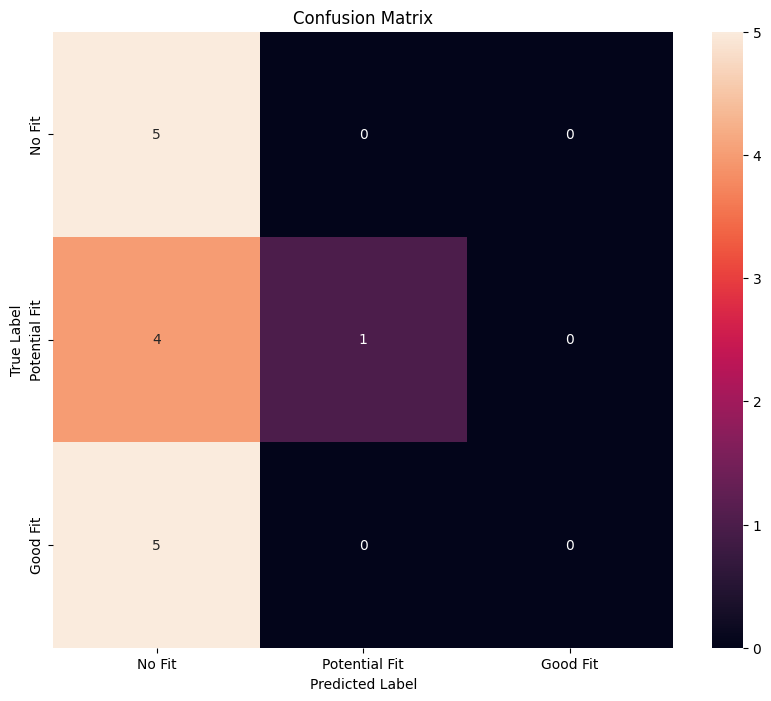


llama2 - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 0.250
Recall: 0.400
F1-score: 0.308
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.429
Recall: 0.600
F1-score: 0.500
Support: 5

Macro Averages:
Precision: 0.226
Recall: 0.333
F1-score: 0.269


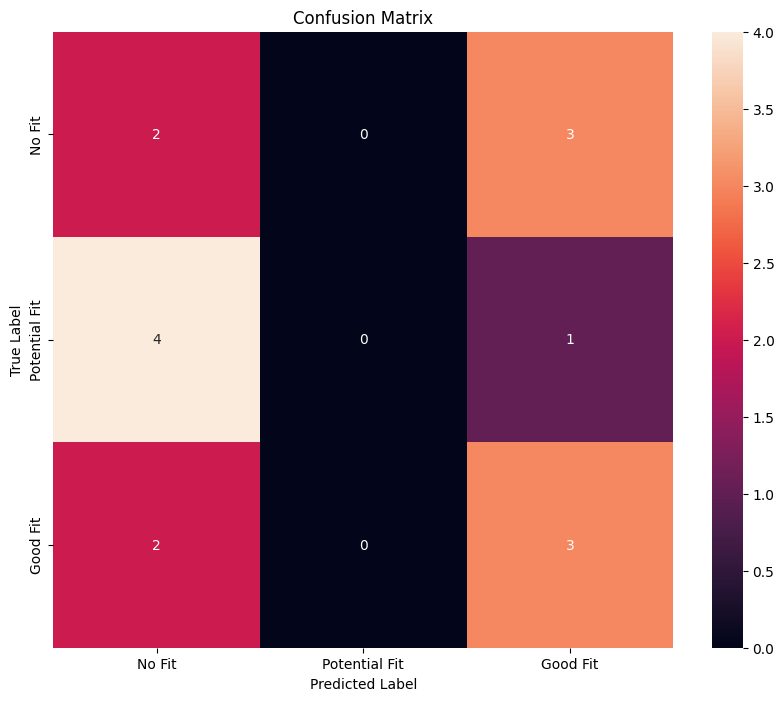


llama2 - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 0.385
Recall: 1.000
F1-score: 0.556
Support: 5

Potential Fit:
Precision: 0.500
Recall: 0.200
F1-score: 0.286
Support: 5

Good Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Macro Averages:
Precision: 0.295
Recall: 0.400
F1-score: 0.280


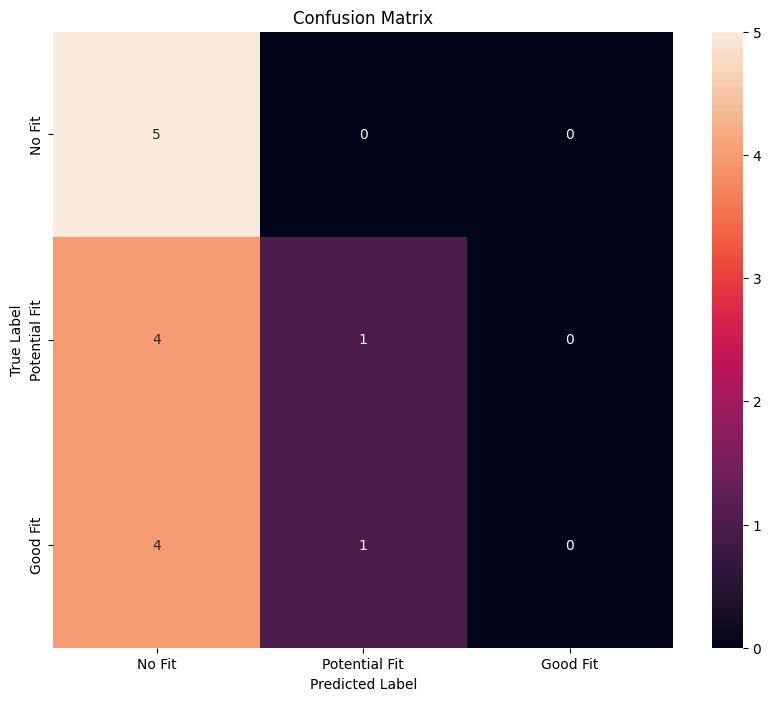

In [ ]:
 # Cell 8: Run analysis for specific model
# Choose which model to run:
model_key = 'llama2'
analyze_with_model(model_key, sample_size=5)


Dataset Info:
Total samples: 6241

Label Distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64

Testing with mistral
Initializing mistral...
CUDA is available. Using GPU: Tesla T4
Model loaded successfully

Analyzing 15 resume-job pairs...


  7%|▋         | 1/15 [00:49<11:35, 49.71s/it]


Analyzing Pair 5330:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
 Final Classification: Potential Fit

Explanation:

1. Job Requirements Analysis:
   - Professional Domain: Salesforce Industries Communications Cloud, Telecom domain
   - Required Technical Skills: SFDC, Vlocity, Omnistudio, Salesforce API framework, 3rd party APIs, Source Control & deployments
   - Required Experience Level: 10+ years in SFDC, 5+ years in Telecom domain

2. Resume Analysis:
   - Candidate's Professional Domain: IT Business Technical Engineer, Salesforce Industries Communications cloud (indirectly)
   - Candidate's Technical Skills: Worked with multiple databases servers such as MySQL, SQL Server, Oracle; has experience in SFDC-related roles but not explicitly stated as Vlocity or Omnistudio
   - Candidate's Experience Level: 10 years total experience, some overlap with the required 5+ years in Telecom domain

3. Direct Compar

 13%|█▎        | 2/15 [01:05<06:30, 30.05s/it]


Analyzing Pair 4806:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Electrical Engineering
- Technical Skills: Reading and understanding of schematics, bloc diagrams, wire lists, functional diagrams, basic electronics, 12VDC-72VDC and 24VAC-480VAC systems, good working knowledge with the use of computers, data recorders, digital millimetres, various measurement instruments, pneumatichydraulic gauges.
- Required Experience Level: Minimum 5 years in related field (Electrical testing)

2. Resume Analysis:
- Professional Domain: Electrical Engineer
- Technical Skills: basic, C, cables, closing, DC, English, inspection, Insulation, Italian, maintenance schedule, mechanical, excel, PowerPoint, word, works, mill, multi-meters, Multi meter, NEC, Programming, Reading, report, requirement, RMS, safety, soldering, Switch, transformers, transformer 7, Troubleshooting, Ty

 20%|██        | 3/15 [01:25<05:02, 25.22s/it]


Analyzing Pair 6034:
Actual Label: Good Fit

Zero-shot Analysis:
 Good Fit: The candidate has extensive experience as a Business Analyst (8 years) and SQL (8 years). They also have the required Systems Testing (Unit, Integration, UAT) experience (8 years). Their communication skills are excellent (4/preferred), and they have experience with Agile Software Development Methodologies (2/preferred). The candidate's domain is Business Analysis and has relevant technical skills. However, they lack Project and Product Management experience (1/preferred). Since the candidate meets all three criteria for Good Fit, that is the classification to be used.

Two-shot Analysis:
 Based on the provided job description and candidate qualifications, the classification is "Good Fit". The candidate has extensive experience as a Business Analyst (8 years), SQL Experience (8 years), Systems Testing (8 years), System Reporting (Oracle, SQL) (8 years), and Agile Software Development Methodologies Experience (

 27%|██▋       | 4/15 [01:39<03:50, 21.00s/it]


Analyzing Pair 5200:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Front End Software Engineer
- Required Technical Skills: Angular, React, StencilJS, Three.js, WebComponents, Unity development (or C#), Progressive Web Apps (PWAs)
- Required Experience Level: Bachelor's, Master's or PhD in Computer Science, Web Design, User Experience, Interaction Design, Visual Design or relevant field with experience in Human Computer Interaction

2. Resume Analysis:
- Professional Domain: Front End UI Developer (closely related to Front End Software Engineer)
- Technical Skills: JavaScript, JSP, XML, HTML5 /DHTML, DOM, XHTML, jQuery, CSS3, Ajax, Angular.js, Node.js, RESTful/SOAP Web Services, SQL Server and T-SQL servers, Hadoop, Hive, Postgres, Cassandra, Mongo, CISA, PYTHON, CISM, Powershell, Perl, automation testing with Mocha and Jasmine using Selenium, Jasmine framew

 33%|███▎      | 5/15 [01:57<03:15, 19.59s/it]


Analyzing Pair 5455:
Actual Label: Good Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit: The candidate has a strong background in software development, specifically with Java, AWS, and SQL which are mentioned in the job description. However, the candidate lacks a degree in Computer Science or equivalent as required by the job description. Additionally, while the candidate has experience working across multiple teams to deliver high-quality products, it is not specified that this experience is in a Fintech background or Payments specifically, which is another requirement of the job. The candidate's experience in software architecture and project management may also be beneficial for the role as a lead software developer.

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Software Engineering (specifically Lead Software Developer)
- Required Technical Skills: Degree in Computer Science, 8+ years of software engineering experience,

 40%|████      | 6/15 [02:14<02:50, 18.94s/it]


Analyzing Pair 4281:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit: The candidate has a general background in software development or similar technical roles, as indicated by their experience in BA and Agile Scrum methodology. However, they do not seem to have specific experience with Scaled Agile Framework (SAFe), Product Owner and/or Scrum Master certification, SharePoint, Microsoft 365, Power BI, or industry experience in professional services, finance, or accounting - which are preferred qualifications mentioned in the job posting. Therefore, they could potentially meet some but not all key requirements for the role at Crowe.

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Product Engineering, Software Development
- Required Technical Skills: Excellent analytical and critical thinking skills, Proficient level of understanding of Product Development and Software Development Life Cycles, Solid expe

 47%|████▋     | 7/15 [02:45<03:01, 22.69s/it]


Analyzing Pair 4686:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit. The job description indicates a need for a data analyst with a focus on finance, which is not an exact match to the candidate's domain (finance and accounting vs software engineering). However, the candidate has relevant technical skills (Tableau and Microsoft Excel) and meets some key requirements (4+ years of experience in an accounting or finance-related role). Therefore, the candidate may be a good fit with some skill gaps to address.

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
 Final Classification: Potential Fit

Explanation:

1. Job Requirements Analysis:
- Professional domain: Finance
- Required technical skills: Tableau, Advanced proficiency with Microsoft Excel
- Required experience level: 4+ years in an accounting or finance-related role

2. Resume Analysis:
- Candidate's professional domain: Electronics and Communication Engineering (Bachelor's degree) and Computer Scie

 53%|█████▎    | 8/15 [03:12<02:49, 24.27s/it]


Analyzing Pair 3612:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Software Engineering (specifically, Salesforce)
- Required Technical Skills: Salesforce Declarative and Programmatic Customization, Salesforce design concepts, Debugging, Querying databases, Version control practices, Financial Services Industry experience
- Required Experience Level: 12 months minimum with a Salesforce background

2. Resume Analysis:
- Candidate's Professional Domain: Software Engineering (broadly)
- Candidate's Technical Skills: UX Design Principles, Performance and Scalability Optimization, Testing and Debugging, Application Design and Development, Data Synchronization, Data Warehousing and Analytics, Advanced Computer Programming, Project Management, Verbal and Written Communication, Cost Estimations, Efficient Data Management, Software Design, Test Planning and QA, 

 60%|██████    | 9/15 [03:28<02:09, 21.63s/it]


Analyzing Pair 4376:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Accounting/Finance (Non-profit industry preferred)
- Required Technical Skills: Strong analytical, organizational and time management skills, understanding of GAAP compliance, Uniform Guidance and OMB Circulars, Excel advanced, proficient in Word and Outlook
- Required Experience Level: Minimum 8+ years accounting experience with progressive and relevant analytical budgeting, analysis, and reporting experience, minimum 5+ years in the nonprofit industry

2. Resume Analysis:
- Candidate's Professional Domain: Accounting/Finance (Based on job titles and responsibilities)
- Candidate's Technical Skills: Strong analytical skills, organizational and time management skills, understanding of GAAP compliance and accounting competencies, proficient in Excel, Word, and Outlook (Based on job descri

 67%|██████▋   | 10/15 [03:53<01:53, 22.71s/it]


Analyzing Pair 3177:
Actual Label: Potential Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Accounting (specifically manufacturing and cost accounting)
- Required Technical Skills: Strong working knowledge of monthly close process, inventory accounting, and practical experience for 5-10 years
- Required Experience Level: 5-10 years

2. Resume Analysis:
- Candidate's Professional Domain: Accounting (various roles in different industries)
- Candidate's Technical Skills: Strong working knowledge of monthly close process, inventory accounting, cash analysis, problem-solving, critical thinking and analysis, financial reporting, accounts payable and receivable operations, general ledger updates, journal entry preparation, and more.
- Candidate's Experience Level: 4 years at Ocean Spray (Senior Accountant), 2 years at Bridgestone Corporation (Accountant) and 1 year as Sales Tax Audito

 73%|███████▎  | 11/15 [04:19<01:34, 23.64s/it]


Analyzing Pair 2294:
Actual Label: No Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Data Engineering
- Required Technical Skills: Python, Java, Spark, AWS Glue (helpful), SQL, ETL
- Required Experience Level: Minimum 7+ years

2. Resume Analysis:
- Candidate's Professional Domain: Data Engineering
- Candidate's Technical Skills: Python, R, SQL, Hadoop, Apache Spark, Hive, Pig, Kafka, Sqoop, Oozie, Teradata, Snowflake, Amazon S3, EMR, Lambda, Git, Jenkins, Splunk, MS Office, Microsoft Visual C#.NET
- Candidate's Experience Level: 6 years (with relevant experience in data engineering)

3. Direct Comparison:
Domain Match: Yes
Skills Match: Full (Python and Spark are required; the candidate has experience with these technologies)
Experience Match: No (The minimum requirement is 7+ years, but the candidate only has 6 years of experience)

4. Classification Rules:
Good Fit = Domain[

 80%|████████  | 12/15 [04:55<01:21, 27.31s/it]


Analyzing Pair 2949:
Actual Label: No Fit

Zero-shot Analysis:
 Good Fit: The candidate has a background in software engineering which aligns with the professional domain for this role, they possess all the required technical skills such as Java development and Python development, and their experience level matches the requirements mentioned in the job description.

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Software Engineering
- Required Technical Skills: Java, Python, REST API development, Linux/Unix, microservices, data structures, algorithms, operating systems, distributed systems, relational databases, NoSQL systems, storage, distributed persistence, troubleshooting, debugging, performance tuning, excellent written and verbal communication skills.
- Required Experience Level: BS or MS degree in Computer Science or equivalent experience, ability to obtain US Government security clearance, minimum 8 years in a

 87%|████████▋ | 13/15 [05:28<00:58, 29.10s/it]


Analyzing Pair 3061:
Actual Label: No Fit

Zero-shot Analysis:
 Based on the job description provided and the resume, this candidate's qualification falls into the "Potential Fit" category. The candidate has extensive experience in software quality process management within the financial software industry, but the specific domain required for the JDE Business Analyst role is different (JDE World Homebuilder). While the candidate does not have direct experience with the JDE World Homebuilder, they do possess transferable skills such as process management, business analysis, and data analysis that could be relevant to the role. However, there seems to be a skill gap in terms of direct experience with the required technical skills (JDE World Homebuilder, Job Cost, and Procurement module functions). Therefore, while their general domain (software) matches, they do not have all the critical technical skills required for a "Good Fit."

Two-shot Analysis:
 Potential Fit: The resume provides 

 93%|█████████▎| 14/15 [05:52<00:27, 27.59s/it]


Analyzing Pair 1326:
Actual Label: No Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Electrical Engineering
- Required Technical Skills: Schematic capture & PCB design, Impedance matching, Simulation of hardware circuits, LabVIEW test automation software, Soldering skills
- Required Experience Level: Rising Senior standing towards a bachelors degree in electrical engineering or equivalent experience

2. Resume Analysis:
- Professional Domain: Network Engineering (based on the candidate's previous work experience)
- Candidate's Technical Skills: Network Design, Troubleshooting, LabVIEW programming, Soldering skills
- Candidate's Experience Level: Experienced Professional with a Bachelor's degree in Computer Science

3. Direct Comparison:
Domain Match: No
Skills Match: Partial (LabVIEW programming, Soldering skills)
Experience Match: No (Candidate has more experience than the req

100%|██████████| 15/15 [06:27<00:00, 25.81s/it]


Analyzing Pair 696:
Actual Label: No Fit

Zero-shot Analysis:
 Potential Fit

Two-shot Analysis:
 Potential Fit

Chain of Thought Analysis:
1. Job Requirements Analysis:
- Professional Domain: Software Engineering
- Required Technical Skills: Java, Python, REST API development, Linux/Unix, microservices, data structures, algorithms, operating systems, distributed systems, relational databases, NoSQL systems, build automation, continuous integration, continuous deployment tools, Infrastructure-As-Code Tools, containerization technologies, IAMSAML authentication, observability tools and practices
- Required Experience Level: BS or MS degree in Computer Science or equivalent experience, ability to obtain US Government security clearance, minimum 8 years in a software-engineering related position, at least half of which was in an AgileDevOps environment, 5+ years of Java development, 5+ years of Python development, 5+ years of experience with REST API development

2. Resume Analysis:
- Ca

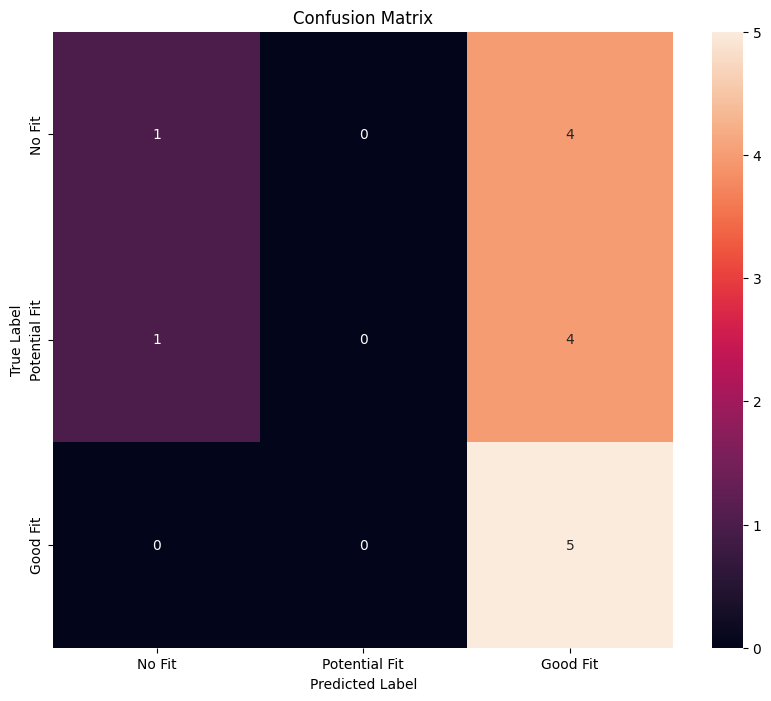


mistral - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 1.000
Recall: 0.200
F1-score: 0.333
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.357
Recall: 1.000
F1-score: 0.526
Support: 5

Macro Averages:
Precision: 0.452
Recall: 0.400
F1-score: 0.287


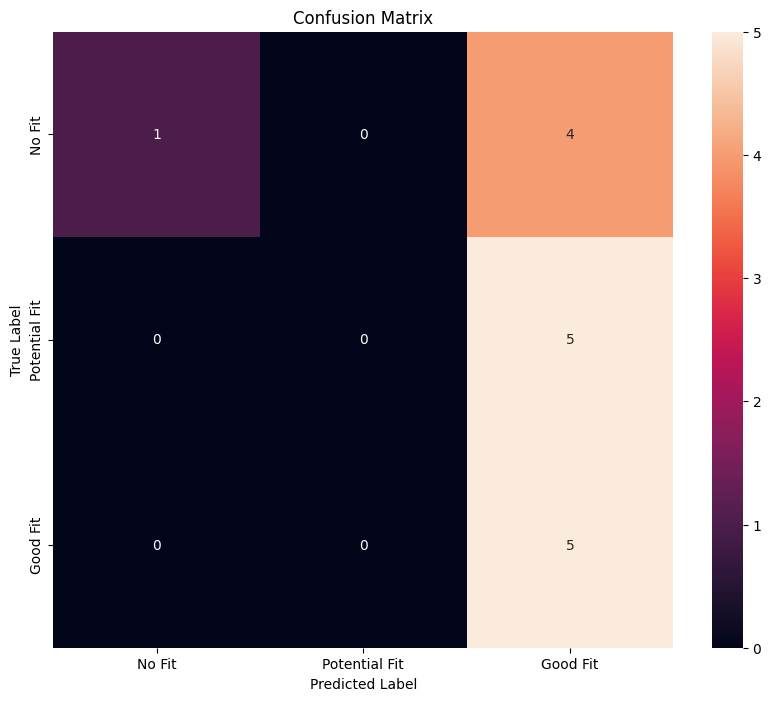


mistral - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 0.667
Recall: 0.800
F1-score: 0.727
Support: 5

Potential Fit:
Precision: 0.625
Recall: 1.000
F1-score: 0.769
Support: 5

Good Fit:
Precision: 1.000
Recall: 0.200
F1-score: 0.333
Support: 5

Macro Averages:
Precision: 0.764
Recall: 0.667
F1-score: 0.610


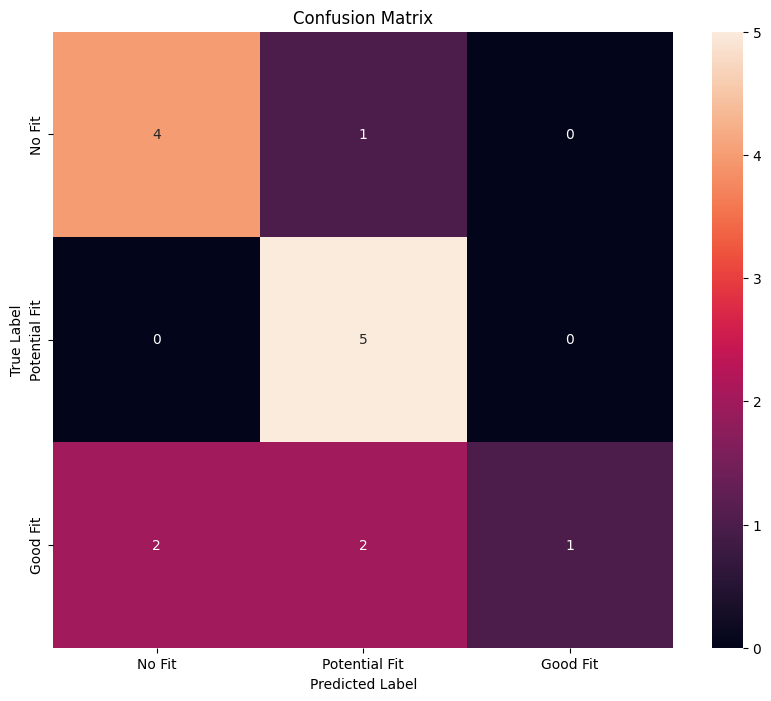

In [ ]:
# Cell 8: Run analysis for specific model
# Choose which model to run:
model_key = 'mistral'
analyze_with_model(model_key, sample_size=5)

```
llama3.1 - Zero-shot Results:

Detailed Metrics for Zero-shot:
----------------------------------------

No Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Potential Fit:
Precision: 0.600
Recall: 0.600
F1-score: 0.600
Support: 5

Good Fit:
Precision: 0.300
Recall: 0.600
F1-score: 0.400
Support: 5

Macro Averages:
Precision: 0.300
Recall: 0.400
F1-score: 0.333



llama3.1 - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Potential Fit:
Precision: 0.500
Recall: 0.800
F1-score: 0.615
Support: 5

Good Fit:
Precision: 0.286
Recall: 0.400
F1-score: 0.333
Support: 5

Macro Averages:
Precision: 0.262
Recall: 0.400
F1-score: 0.316


llama3.1 - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 1.000
Recall: 0.600
F1-score: 0.750
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.444
Recall: 0.800
F1-score: 0.571
Support: 5

Macro Averages:
Precision: 0.481
Recall: 0.467
F1-score: 0.440
```

```
llama2 - Zero-shot Results:

Detailed Metrics for Zero-shot:
----------------------------------------

No Fit:
Precision: 0.357
Recall: 1.000
F1-score: 0.526
Support: 5

Potential Fit:
Precision: 1.000
Recall: 0.200
F1-score: 0.333
Support: 5

Good Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Macro Averages:
Precision: 0.452
Recall: 0.400
F1-score: 0.287



llama2 - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 0.250
Recall: 0.400
F1-score: 0.308
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.429
Recall: 0.600
F1-score: 0.500
Support: 5

Macro Averages:
Precision: 0.226
Recall: 0.333
F1-score: 0.269


llama2 - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 0.385
Recall: 1.000
F1-score: 0.556
Support: 5

Potential Fit:
Precision: 0.500
Recall: 0.200
F1-score: 0.286
Support: 5

Good Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Macro Averages:
Precision: 0.295
Recall: 0.400
F1-score: 0.280

```

```
mistral - Zero-shot Results:

Detailed Metrics for Zero-shot:
----------------------------------------

No Fit:
Precision: 0.500
Recall: 0.200
F1-score: 0.286
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.385
Recall: 1.000
F1-score: 0.556
Support: 5

Macro Averages:
Precision: 0.295
Recall: 0.400
F1-score: 0.280



mistral - Two-shot Results:

Detailed Metrics for Two-shot:
----------------------------------------

No Fit:
Precision: 1.000
Recall: 0.200
F1-score: 0.333
Support: 5

Potential Fit:
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Support: 5

Good Fit:
Precision: 0.357
Recall: 1.000
F1-score: 0.526
Support: 5

Macro Averages:
Precision: 0.452
Recall: 0.400
F1-score: 0.287


mistral - Chain-of-Thought Results:

Detailed Metrics for Chain-of-Thought:
----------------------------------------

No Fit:
Precision: 0.667
Recall: 0.800
F1-score: 0.727
Support: 5

Potential Fit:
Precision: 0.625
Recall: 1.000
F1-score: 0.769
Support: 5

Good Fit:
Precision: 1.000
Recall: 0.200
F1-score: 0.333
Support: 5

Macro Averages:
Precision: 0.764
Recall: 0.667
F1-score: 0.610
```

F1-score:

|                | llama3.1 | llama2 | mistral |
|----------------|----------|--------|---------|
| zero-shot      | 0.333    | 0.287  | 0.280   |
| two-shot       | 0.316    | 0.269  | 0.287   |
| chain-of-thought | 0.440    | 0.280  | 0.610   |
